## Attention based Spatial-Temporal Graph Convolution Cell
Model that chains blocks containing a temporal and a spatial attention layer follwed by <br />
a convolution layer on the time axis. <br /> <br />

<pre>
 &#8625;  res_channels   &#10141;                                             &#8628; <br />
&#10141; [temp_attention &#10141; spatial_attention &#10141; time_conv] &#10141; block_out + residual &#10141; ... &#10141; last_block_out <br />
                                                                                            &#8681; <br />
                                                                                        prediction
</pre>

### ASTGCN

100%|██████████| 1000/1000 [16:16<00:00,  1.02it/s]


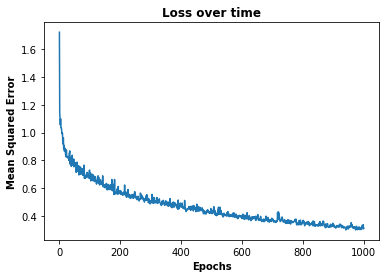

Train MSE: 0.3109
Test MSE: 1.1823


In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch_geometric_temporal.nn.attention import ASTGCN
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

from torch_geometric.data import DataLoader

loader = ChickenpoxDatasetLoader()

lags = 10
stride = 1
epochs = 1000
batch_size = 32

dataset = loader.get_dataset(lags)

sample = next(iter(dataset))
num_nodes = sample.x.size(0)
edge_index = sample.edge_index

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.4)

train_loader = DataLoader(list(train_dataset), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(test_dataset), batch_size=batch_size, shuffle=False)

### MODEL DEFINITION
class AttentionGCN(nn.Module):
    def __init__(self):
        super(AttentionGCN, self).__init__()

        self.attention = ASTGCN(
            nb_block=3,
            in_channels=1,
            K=3,
            nb_chev_filter=16,
            nb_time_filter=16,
            time_strides=1,
            num_for_predict=1,
            len_input=lags,
            num_of_vertices=num_nodes,
            normalization='sym',
            bias=True,
        )

    def forward(self, window):     
        x = window.x.view(-1, num_nodes, 1, lags)    
        x = self.attention(x, edge_index)        
        return x.squeeze(1).permute(0,2,1).flatten()
    
model = AttentionGCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### TRAIN
model.train()

loss_history = []
for _ in tqdm(range(epochs)):
    total_loss = 0
    for i, window in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(window)
        
        assert y_pred.shape == window.y.shape
        loss = torch.mean((y_pred - window.y)**2)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    total_loss /= i+1
    loss_history.append(total_loss)

### TEST 
model.eval()
loss = 0
with torch.no_grad():
    for i, window in enumerate(test_loader):
        y_pred = model(window)
        
        assert y_pred.shape == window.y.shape
        loss += torch.mean((y_pred - window.y)**2)
    loss /= i+1

### RESULTS PLOT
fig, ax = plt.subplots()

x_ticks = np.arange(1, epochs+1)
ax.plot(x_ticks, loss_history)

# figure labels
ax.set_title('Loss over time', fontweight='bold')
ax.set_xlabel('Epochs', fontweight='bold')
ax.set_ylabel('Mean Squared Error', fontweight='bold')
plt.show()

print("Train MSE: {:.4f}".format(total_loss))
print("Test MSE: {:.4f}".format(loss))
